In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

In [17]:
columns = ['Capture_time', 'Id']
print('Reading CSV...')
print(datetime.datetime.now())

data = pd.read_csv('../evo_data_menor.csv', usecols=columns, nrows=30000000)

print(datetime.datetime.now())
print('Finish\n')

Reading CSV...
2018-08-19 16:01:25.545936
2018-08-19 16:07:40.168726
Finish



In [33]:
data.head()

,Capture_time,Id
0,2018-03-01 08:24:51.795031-08:00,JTDKDTB31J1599606
1,2018-03-01 08:24:51.795031-08:00,JTDKDTB31H1597557
2,2018-03-01 08:24:51.795031-08:00,JTDKDTB36E1079858
3,2018-03-01 08:24:51.795031-08:00,JTDKDTB33F1101042
4,2018-03-01 08:24:51.795031-08:00,JTDKDTB32G1118514


In [31]:
# Colleting vehicle ids
car_ids = list(data.Id.unique())

# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
ids_uncommon = [id for id in car_ids if id.find('-') != -1]
car_ids = [id for id in car_ids if id.find('-') == -1]

print('Data len before remove uncommon ids: '+str(len(data)))
data = data[~data.Id.isin(ids_uncommon)]
print('Data len after remove uncommon ids: '+str(len(data)))

Data len before remove uncommon ids: 30000000
Data len after remove uncommon ids: 29999500


In [48]:
def str_to_datetime(df_time):
    """ 
    Reformatando de string para datetime.
    
    Parameters
    ----------
    df_time : pandas.DataFrame, string
        Dataframe com strings a serem convertidas para datetime.
    
    Returns
    ----------
    date_list : pandas.DataFrame, datetime
        Dataframe com valores em datetime para possíveis fusos de Vancouver.
    
    """
    date_list = []
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    
    
    for date in df_time:
        for fmt in format_string:
            try:
                date_list.append(datetime.datetime.strptime(str(date), fmt))
                break
            except:
                pass
            
    
    return pd.DataFrame(date_list)

In [50]:
print('Date strings to Datetime type\n')
data['Capture_time'] = str_to_datetime(data['Capture_time'])

In [51]:
data.head()

,Capture_time,Id
0,2018-03-01 08:24:51.795031,JTDKDTB31J1599606
1,2018-03-01 08:24:51.795031,JTDKDTB31H1597557
2,2018-03-01 08:24:51.795031,JTDKDTB36E1079858
3,2018-03-01 08:24:51.795031,JTDKDTB33F1101042
4,2018-03-01 08:24:51.795031,JTDKDTB32G1118514


In [77]:
print(datetime.datetime.now())
print('Filtering per dayweek')

parked = 0
andando_weekdays = []
andando_weekends = []

data = data.sort_index(by='Capture_time')
data.index = range(len(data))
# Percorre todo o dataframe para verificar quantos carros estão andando em dado minuto
for i in range(1, len(data)):
    start_time_atual = int(data['Capture_time'].iloc[i].timestamp())

    start_time_anterior = int(data['Capture_time'].iloc[i-1].timestamp())
    
    # Enquanto está no mesmo minuto, é analisado se o carro está parado
    if (start_time_atual == start_time_anterior):
        parked += 1
    else:
        # Carros viajando são dados pelo total de carros da frota menos os que estão atualmente estacionados
        in_travel = len(car_ids) - parked
        
        porcentagem = (in_travel/len(car_ids))*100
        
        # Verifica que a data está entre segunda(1) e sexta(5)
        if (int(datetime.datetime.fromtimestamp(start_time_anterior).strftime('%w')) > 0 and 
            int(datetime.datetime.fromtimestamp(start_time_anterior).strftime('%w')) < 6):
            andando_weekdays.append([start_time_anterior, in_travel, porcentagem])
        else:
            andando_weekends.append([start_time_anterior, in_travel, porcentagem])
            
        parked = 0
dfIn_Travel_weekdays = pd.DataFrame(andando_weekdays, columns=['capture_time', 'total_in_travel', 'percentage'])
dfIn_Travel_weekends = pd.DataFrame(andando_weekends, columns=['capture_time', 'total_in_travel', 'percentage'])

print(datetime.datetime.now())

/home/victor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  """


2018-08-18 12:58:47.471792
2018-08-18 17:12:23.448700


In [93]:
dfIn_Travel_weekdays.head()

,capture_time,total_in_travel,percentage
0,2018-03-01 08:24:51,524,44.107744
1,2018-03-01 08:25:53,524,44.107744
2,2018-03-01 08:26:55,491,41.329966
3,2018-03-01 08:27:58,524,44.107744
4,2018-03-01 08:29:00,524,44.107744


In [89]:
def from_timestamp_list(timestamp_list):
    
    datetime_list = []
    
    for date in timestamp_list:
        datetime_list.append(datetime.datetime.fromtimestamp(int(date)))
    
    return pd.DataFrame(datetime_list)

In [ ]:
# Formatando os dados de unix timestamp para datetime

dfWeekdays = dfIn_Travel_weekdays

dfWeekdays['capture_time'] = from_timestamp_list(dfWeekdays['capture_time'])    
    
    
dfWeekends = dfIn_Travel_weekends

dfWeekends['capture_time'] = from_timestamp_list(dfWeekends['capture_time'])

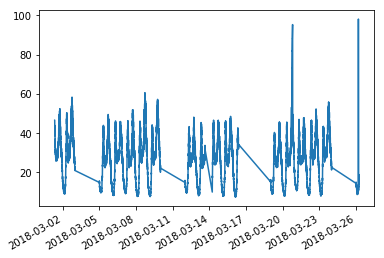

In [10]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfWeekdays['capture_time'],dfWeekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

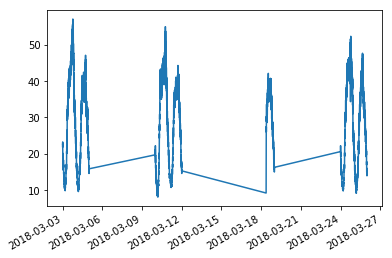

In [11]:
# Plot da porcentagem de carros alocados em dias de final de semana
plt.plot(dfWeekends['capture_time'],dfWeekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [13]:
dfWeekends.to_csv('weekends.csv', index=False, encoding='utf-8')
dfWeekdays.to_csv('weekdays.csv', index=False, encoding='utf-8')

In [2]:
dfWeekdays = pd.read_csv('../plots/weekdays.csv')
dfWeekends = pd.read_csv('../plots/weekends.csv')

In [133]:
# Debug
dfWeekdays.capture_time = pd.to_datetime(dfWeekdays.capture_time)
dfWeekdays['minute'] = dfWeekdays.capture_time.dt.minute
dfWeekdays['hour'] = dfWeekdays.capture_time.dt.hour

In [136]:
# Outlier importante a ser verificado
dfWeekdays[(dfWeekdays.hour == 10) & (dfWeekdays.minute == 32)]

,capture_time,total_in_travel,percentage,minute,hour
117,2018-03-01 10:32:23,365,29.698942,32,10
1422,2018-03-02 10:32:31,346,28.152970,32,10
2718,2018-03-05 10:32:17,296,24.084622,32,10
4027,2018-03-06 10:32:18,340,27.664768,32,10
5337,2018-03-07 10:32:48,1207,98.209927,32,10
6642,2018-03-08 10:32:40,318,25.874695,32,10
7931,2018-03-09 10:32:12,298,24.247356,32,10


In [3]:
dfWeekdays['capture_time'] = pd.to_datetime(dfWeekdays['capture_time'])
dfWeekends['capture_time'] = pd.to_datetime(dfWeekends['capture_time'])

In [4]:
def media(df): 
    """
    Faz a media das porcentagens minuto a minuto de todo o dataset.
    
    Parameters
    ------------
    df : Pandas dataframe
        Dados a serem analisados, com uma coluna dos horários e outra com as porcentagens.
    
    Returns
    ----------
    media : Pandas dataframe
        Dados com a média das porcentagens para 24 horas.
    
    """
    minute = []

    # Criando uma coluna que irá sinalizar a quantidade de minutos corridos até tal registro
    df['minute'] = dfWeekdays.capture_time.dt.minute + (dfWeekdays.capture_time.dt.hour * 60)
    
    # Ordenando o dataset por minutos corridos para facilitar a soma de valores
    df = df.sort_values(by=['minute', 'capture_time'])
    
    min_list = list(df['minute'].unique())
    media = []
    # É percorrido minuto a minuto para se obter a média de porcentagem para cada
    # Assim é formado um dataframe com média de utilização a cada minuto
    for min in min_list:

        occurencies = dfWeekdays[dfWeekdays.minute == min]
    
        media.append([occurencies.capture_time.iloc[0].strftime('%H:%M'), 
                      float(occurencies.percentage.mean()), 
                      float(occurencies.percentage.std())])
    

    media = pd.DataFrame(media, columns=['time', 'mean', 'std'])
    
    return media

In [5]:
# Fazendo a média das porcentagens de cada dia
print('Media')
print(datetime.datetime.now())

dfWeekdays = dfWeekdays.sort_values(by='capture_time')
mediaWeekdays = media(dfWeekdays)

dfWeekends = dfWeekends.sort_values(by='capture_time')
mediaWeekends = media(dfWeekends)
print(datetime.datetime.now())

In [21]:
mediaWeekdays.to_csv('mediaWeekdays.csv', index=False, encoding='utf-8')
mediaWeekends.to_csv('mediaWeekends.csv', index=False, encoding='utf-8')

In [7]:
mediaWeekdays = pd.read_csv('../plots/mediaWeekdays.csv')
mediaWeekends = pd.read_csv('../plots/mediaWeekends.csv')

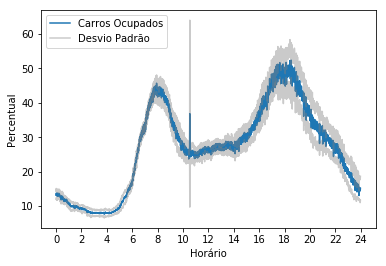

In [3]:
import numpy as np

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Legendas e label dos eixos
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
plt.ylabel('Percentual')
plt.xlabel('Horário')

# Salvando o plot
# plt.savefig('Weekdays_v2.pdf', bbox_inches='tight')

plt.show()

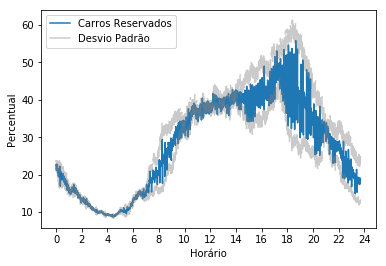

In [4]:
import numpy as np

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Reservados')

# Curvas representando o intervalo de desvio padrão
ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Legendas e label dos eixos
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
plt.ylabel('Percentual')
plt.xlabel('Horário')

# Salvando o plot
# plt.savefig('Weekends_v2.pdf', bbox_inches='tight')

plt.show()

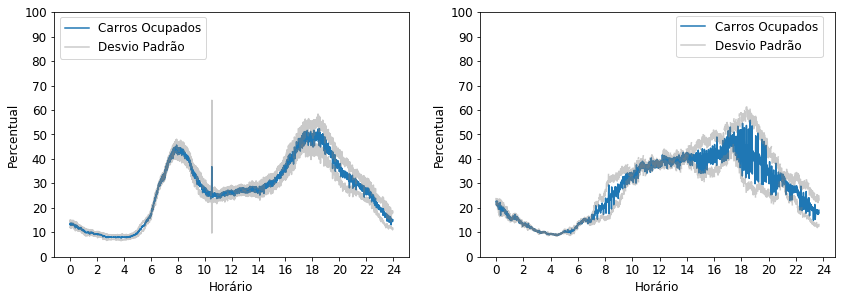

In [9]:

matplotlib.rc('font', size=12)

# Plot das porcentagens dos fins de semana
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(14,4.5)



# Curva dos carros andando

ax1.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
ax1.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

# Modificando os labels das horas e das porcentagens
ax1.xaxis.set_ticks(np.arange(0, 1441, 120))
ax1.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,26,2)

ax1.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax1.set_ylim([0,100])

# Legendas e label dos eixos
ax1.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
ax1.set_ylabel('Percentual')
ax1.set_xlabel('Horário')




# # Curva dos carros andando
ax2.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Ocupados')

# # Curvas representando o intervalo de desvio padrão
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
ax2.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

# Modificando os labels das horas e das porcentagens
ax2.xaxis.set_ticks(np.arange(0, 1441, 120))
ax2.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0,26,2)

ax2.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax2.set_ylim([0,100])

# Legendas e label dos eixos
ax2.legend(bbox_to_anchor=(0.55, 0.99), loc=2, borderaxespad=0.1)
ax2.set_ylabel('Percentual')
ax2.set_xlabel('Horário')


plt.show()
#plt.savefig('plots/ViagensPorHoras_Evo.pdf')